In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import FFT
from darts.metrics import mape,mae,rmse
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

c:\Users\Windows 10\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsforecast\core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [ ]:
# 1. Data preprocessing
df=pd.read_csv('BID-Historical-Data.csv')
df['Date'] = pd.to_datetime(df['Date'],format='mixed')
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df = df[['Date','Price']]
df

In [3]:
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [4]:
# 2. Prepare TimeSeries data
ts = TimeSeries.from_dataframe(df,time_col='Date',value_cols='Price', freq='D')

In [5]:
# 3. Split data into training and test sets

total_length = len(ts)
train_size = int(0.7 * total_length)

train, test = ts.split_before(ts.time_index[train_size])


In [6]:

# 4. Define and fit the FFT model on train set, then make predictions on test set
fft_model = FFT(trend='exp')
model_fit = fft_model.fit(train)

y_pred = model_fit.predict(len(test))

In [ ]:
# 5. Predict for the next 30 days

# Create a date range for the next 30 days
next_30_days_index = pd.date_range(start=test.time_index[0] + pd.DateOffset(days=1), periods=len(test) + 30)
x_30 = pd.to_datetime(next_30_days_index)

# Predict the closing prices for the next 30 days
y_next_30_days = model_fit.predict(len(x_30))
y_next_30_days_trimmed = y_next_30_days[len(test):]

y_pred_30 = TimeSeries.from_times_and_values(
    times= next_30_days_index[len(test):],
    values= y_next_30_days_trimmed.values(),
    fill_missing_dates=True  
)
# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days_trimmed)


In [11]:
# 6. Model evaluation
mape_value = mape(test, y_pred)
mae_value = mae(test, y_pred)
rmse_value = rmse(test, y_pred)

print("Mean Absolute Percentage Error (MAPE):", mape_value)
print("Mean Absolute Error (MAE):", mae_value)
print("Root Mean Squared Error (RMSE):", rmse_value)


Mean Absolute Percentage Error (MAPE): 7.250823179578195
Mean Absolute Error (MAE): 3071.8156727546157
Root Mean Squared Error (RMSE): 3524.176379762283


<Axes: xlabel='time'>

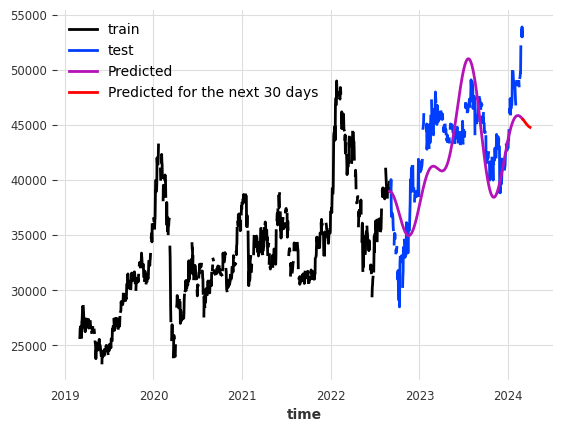

In [12]:
# 7. Plotting
train.plot(label="train")
test.plot(label="test")
y_pred.plot(label="Predicted")
y_pred_30.plot(label="Predicted for the next 30 days", color = 'r')
